# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [5]:
# TODO: Make all necessary imports.
%pip install -q tqdm==4.28.1
%pip install -q -U tensorflow==2.12.0
%pip install -q -U tensorflow_datasets
%pip install matplotlib

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
#print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 Running on CPU')




[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Using:
	• TensorFlow version: 2.12.0
	• Running on CPU


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [9]:
# TODO: Load the dataset with TensorFlow Datasets.

# TODO: Create a training set, a validation set and a test set.
import tensorflow as tf
import tensorflow_datasets as tfds

dataset_name = "oxford_flowers102"
dataset, info = tfds.load(dataset_name, as_supervised=True, with_info=True)


#  train, validation, and test sets
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

# image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 32

# Resize & Normalize
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
    image = image / 255.0  # Normalize to [0,1] range
    return image, label

# Apply preprocessing to datasets
train_data = train_data.map(preprocess).batch(BATCH_SIZE).shuffle(1000)
val_data = val_data.map(preprocess).batch(BATCH_SIZE)
test_data = test_data.map(preprocess).batch(BATCH_SIZE)

# Check dataset info
print(info)

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

## Explore the Dataset

In [10]:
# TODO: Get the number of examples in each set from the dataset info.

# TODO: Get the number of classes in the dataset from the dataset info.
# Get the number of examples in each dataset split
num_train = info.splits['train'].num_examples
num_val = info.splits['validation'].num_examples
num_test = info.splits['test'].num_examples

# Get the number of classes
num_classes = info.features['label'].num_classes

print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")
print(f"Number of test examples: {num_test}")
print(f"Number of classes: {num_classes}")

Number of training examples: 1020
Number of validation examples: 1020
Number of test examples: 6149
Number of classes: 102


In [11]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
# Get 3 samples from the training dataset
train_examples = dataset['train'].take(3)

# Print the shape and corresponding label
for image, label in train_examples:
    print(f"Image shape: {image.shape}, Label: {label.numpy()}")


Image shape: (500, 667, 3), Label: 72
Image shape: (500, 666, 3), Label: 84
Image shape: (670, 500, 3), Label: 70


2025-02-17 20:00:09.399985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2025-02-17 20:00:09.400491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


2025-02-17 20:00:17.241692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2025-02-17 20:00:17.242172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


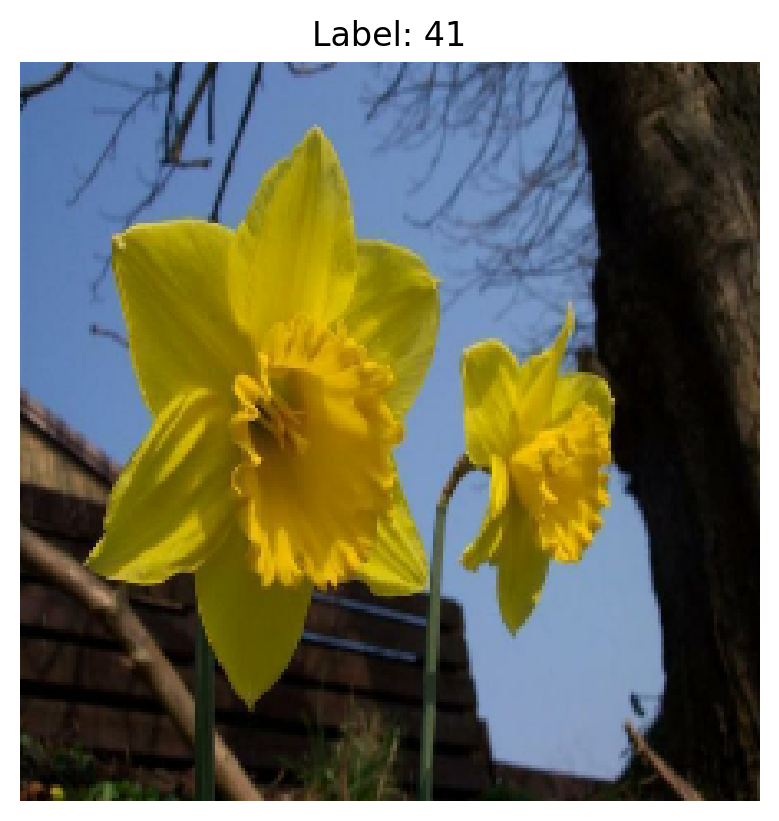

In [12]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 


import matplotlib.pyplot as plt

# Take one image from the training set
for image, label in train_data.take(1):  
    image = image.numpy()[0]  # Convert tensor to NumPy array
    label = label.numpy()[0]  # Convert tensor to integer

    # Plot the image
    plt.imshow(image)
    plt.title(f"Label: {label}")  # Set title to label
    plt.axis("off")  # Hide axes
    plt.show()
    break


### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [13]:
import json

# Load the label mapping from the label_map.json file
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

# Example: Convert label to category name using class_names
label = '70'  # This would be the predicted label (as a string)
category_name = class_names[label]
print(f'Predicted label {label} corresponds to the category: {category_name}')


Predicted label 70 corresponds to the category: gazania


2025-02-17 20:00:38.147426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2025-02-17 20:00:38.147880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


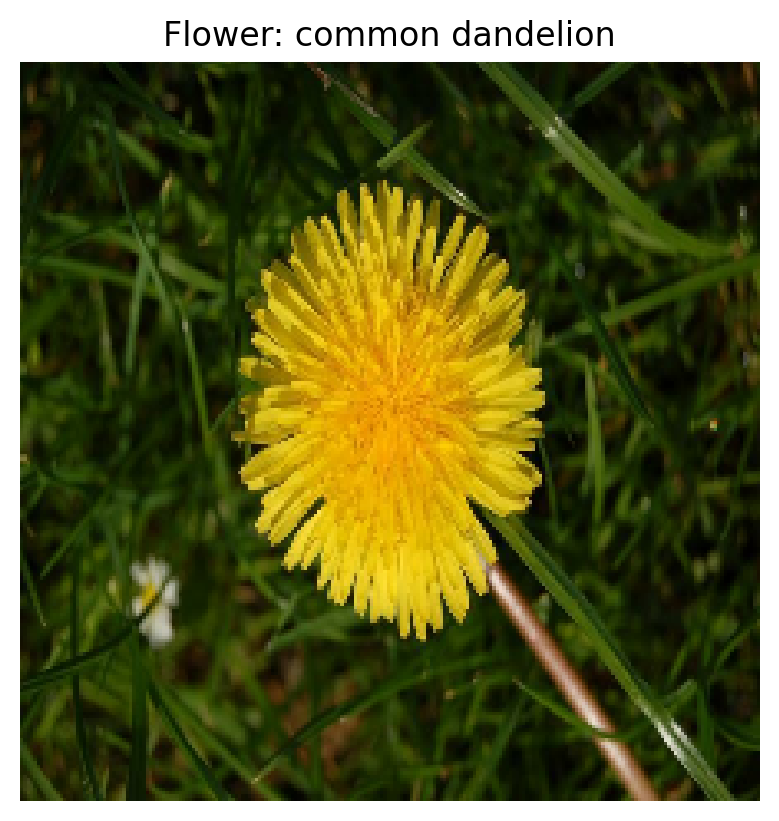

In [14]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 


import matplotlib.pyplot as plt

# Take one image from the training set
for image, label in train_data.take(1):  
    image = image.numpy()[0]  # Convert tensor to NumPy array
    label = label.numpy()[0]  # Convert tensor to integer

    # Get the corresponding class name
    class_name = class_names[str(label)]  # Labels are stored as strings in JSON

    # Plot the image
    plt.imshow(image)
    plt.title(f"Flower: {class_name}")  # Set title to class name
    plt.axis("off")  # Hide axes
    plt.show()
    break



## Create Pipeline

In [15]:
# TODO: Create a pipeline for each set.


# Define image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 32

# Function to preprocess images: resize & normalize
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
    image = image / 255.0  # Normalize to [0,1] range
    return image, label

# Create the pipeline for each set: train, validation, and test
train_data = dataset['train'].map(preprocess).batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)
val_data = dataset['validation'].map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_data = dataset['test'].map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Check the pipeline
print(f"Training data pipeline: {train_data}")
print(f"Validation data pipeline: {val_data}")
print(f"Test data pipeline: {test_data}")




Training data pipeline: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Validation data pipeline: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Test data pipeline: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10


2025-02-17 20:00:53.470460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2025-02-17 20:00:53.470889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


32/32 [==============================] - ETA: 0s - loss: 3.8849 - accuracy: 0.1990

2025-02-17 20:02:27.234370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2025-02-17 20:02:27.234974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 175s 5s/step - loss: 3.8849 - accuracy: 0.1990 - val_loss: 2.4061 - val_accuracy: 0.4980
Epoch 2/10
32/32 [==============================] - 171s 5s/step - loss: 1.2633 - accuracy: 0.7245 - val_loss: 1.4188 - val_accuracy: 0.6578
Epoch 3/10
32/32 [==============================] - 165s 5s/step - loss: 0.4516 - accuracy: 0.9059 - val_loss: 1.1180 - val_accuracy: 0.7235
Epoch 4/10
32/32 [==============================] - 150s 5s/step - loss: 0.2367 - accuracy: 0.9667 - val_loss: 0.9874 - val_accuracy: 0.7422
Epoch 5/10
32/32 [==============================] - 153s 5s/step - loss: 0.1226 - accuracy: 0.9863 - val_loss: 0.8731 - val_accuracy: 0.7539
Epoch 6/10
32/32 [==============================] - 143s 4s/step - loss: 0.0645 - accuracy: 0.9980 - val_loss: 0.8507 - val_accuracy: 0.7676
Epoch 7/10
32/32 [==============================] - 153s 5s/step - loss: 0.0434 - accuracy: 0.9951 - val_loss: 0.8129 - val_accuracy: 0.7892
Epoch 8/10
32/32 [======

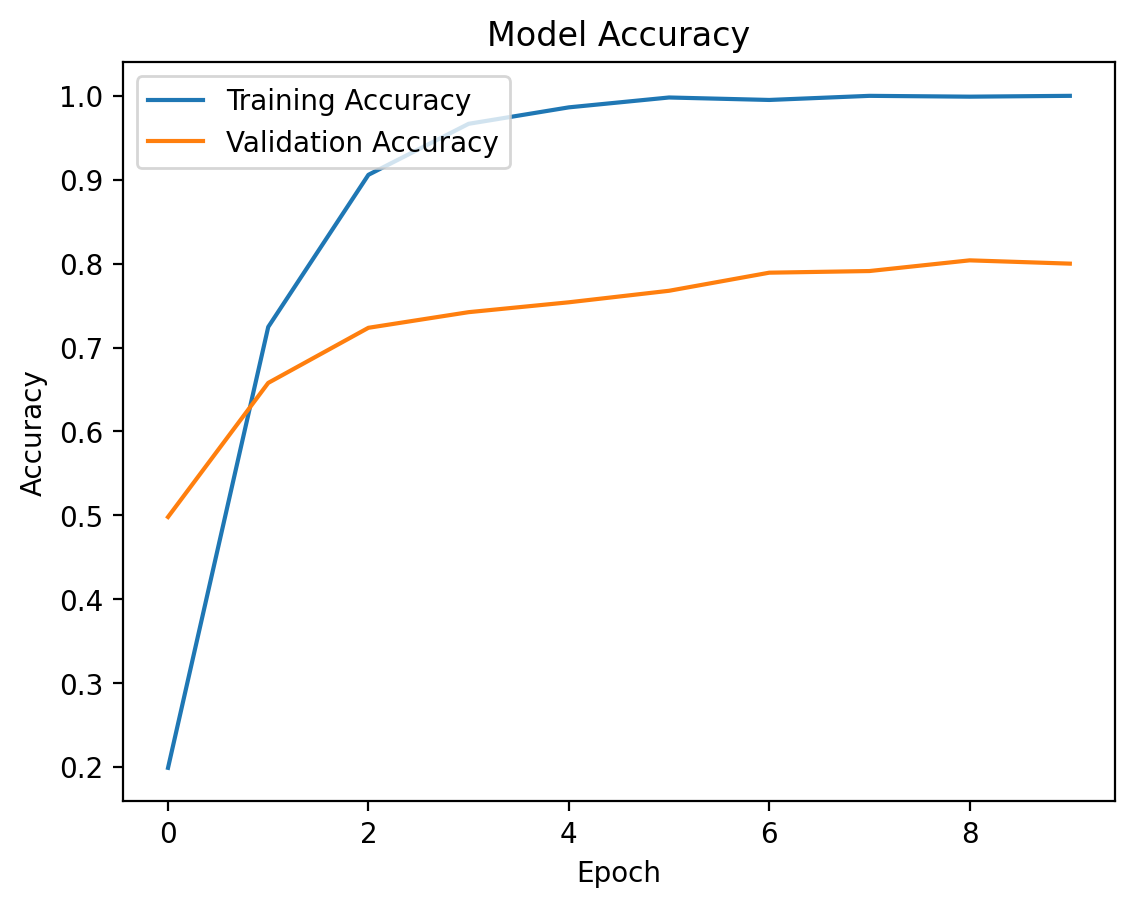

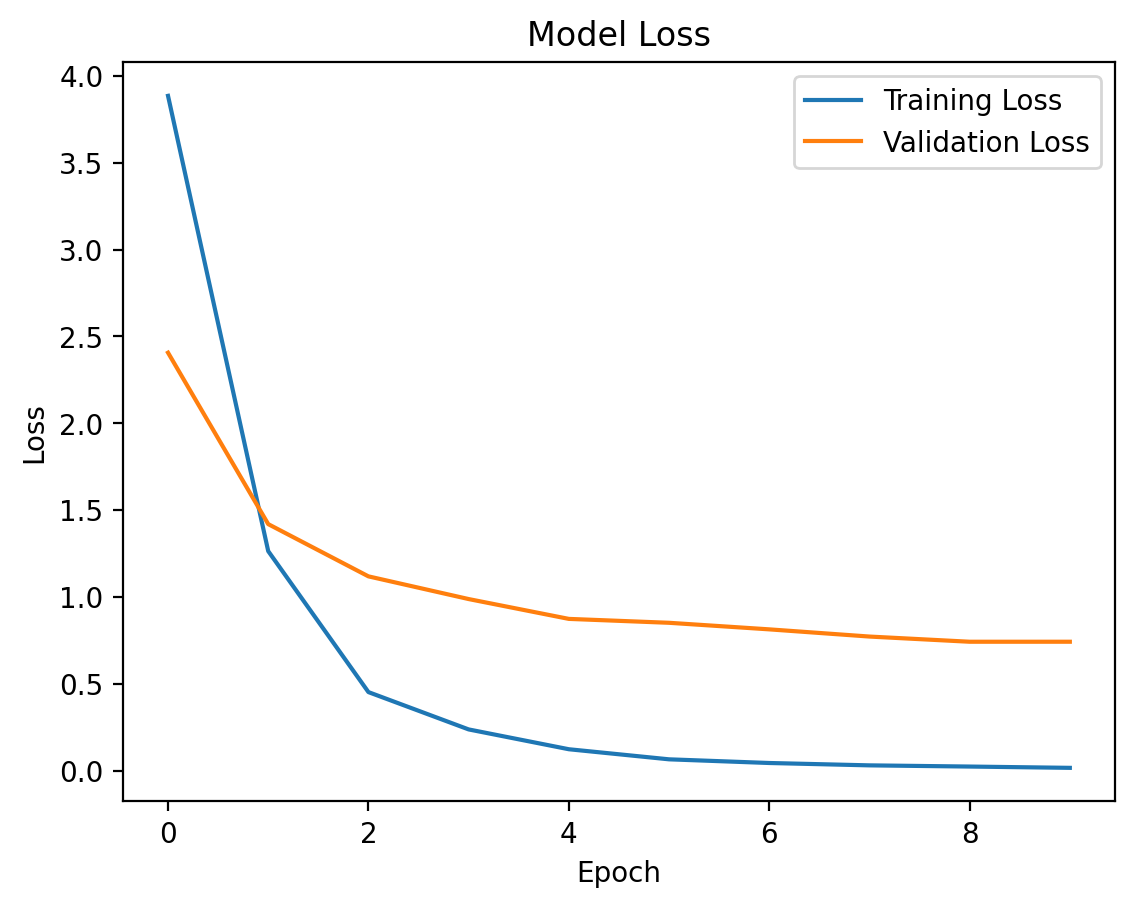

In [16]:
# TODO: Build and train your network.
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model pre-trained on ImageNet
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of MobileNetV2 (we'll only train the new classifier layers)
mobilenet_model.trainable = False

# Build the model with a new feed-forward classifier on top of MobileNetV2
model = models.Sequential([
    mobilenet_model,  # Pre-trained MobileNetV2 model
    layers.GlobalAveragePooling2D(),  # Global Average Pooling layer to reduce the spatial dimensions
    layers.Dense(1024, activation='relu'),  # Dense layer with 1024 units and ReLU activation
    layers.Dropout(0.2),  # Dropout layer to reduce overfitting
    layers.Dense(102, activation='softmax')  # Output layer with 102 units (one for each class)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',  # We are using integer labels
              metrics=['accuracy'])

# Train the model (use your train_data and val_data variables)
history = model.fit(train_data,  # Training dataset
                    epochs=10,  # Number of epochs to train the model
                    validation_data=val_data)  # Validation dataset

# Optionally, save the trained model
model.save('flower_classifier_model.h5')

# Plot the loss and accuracy during training
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()




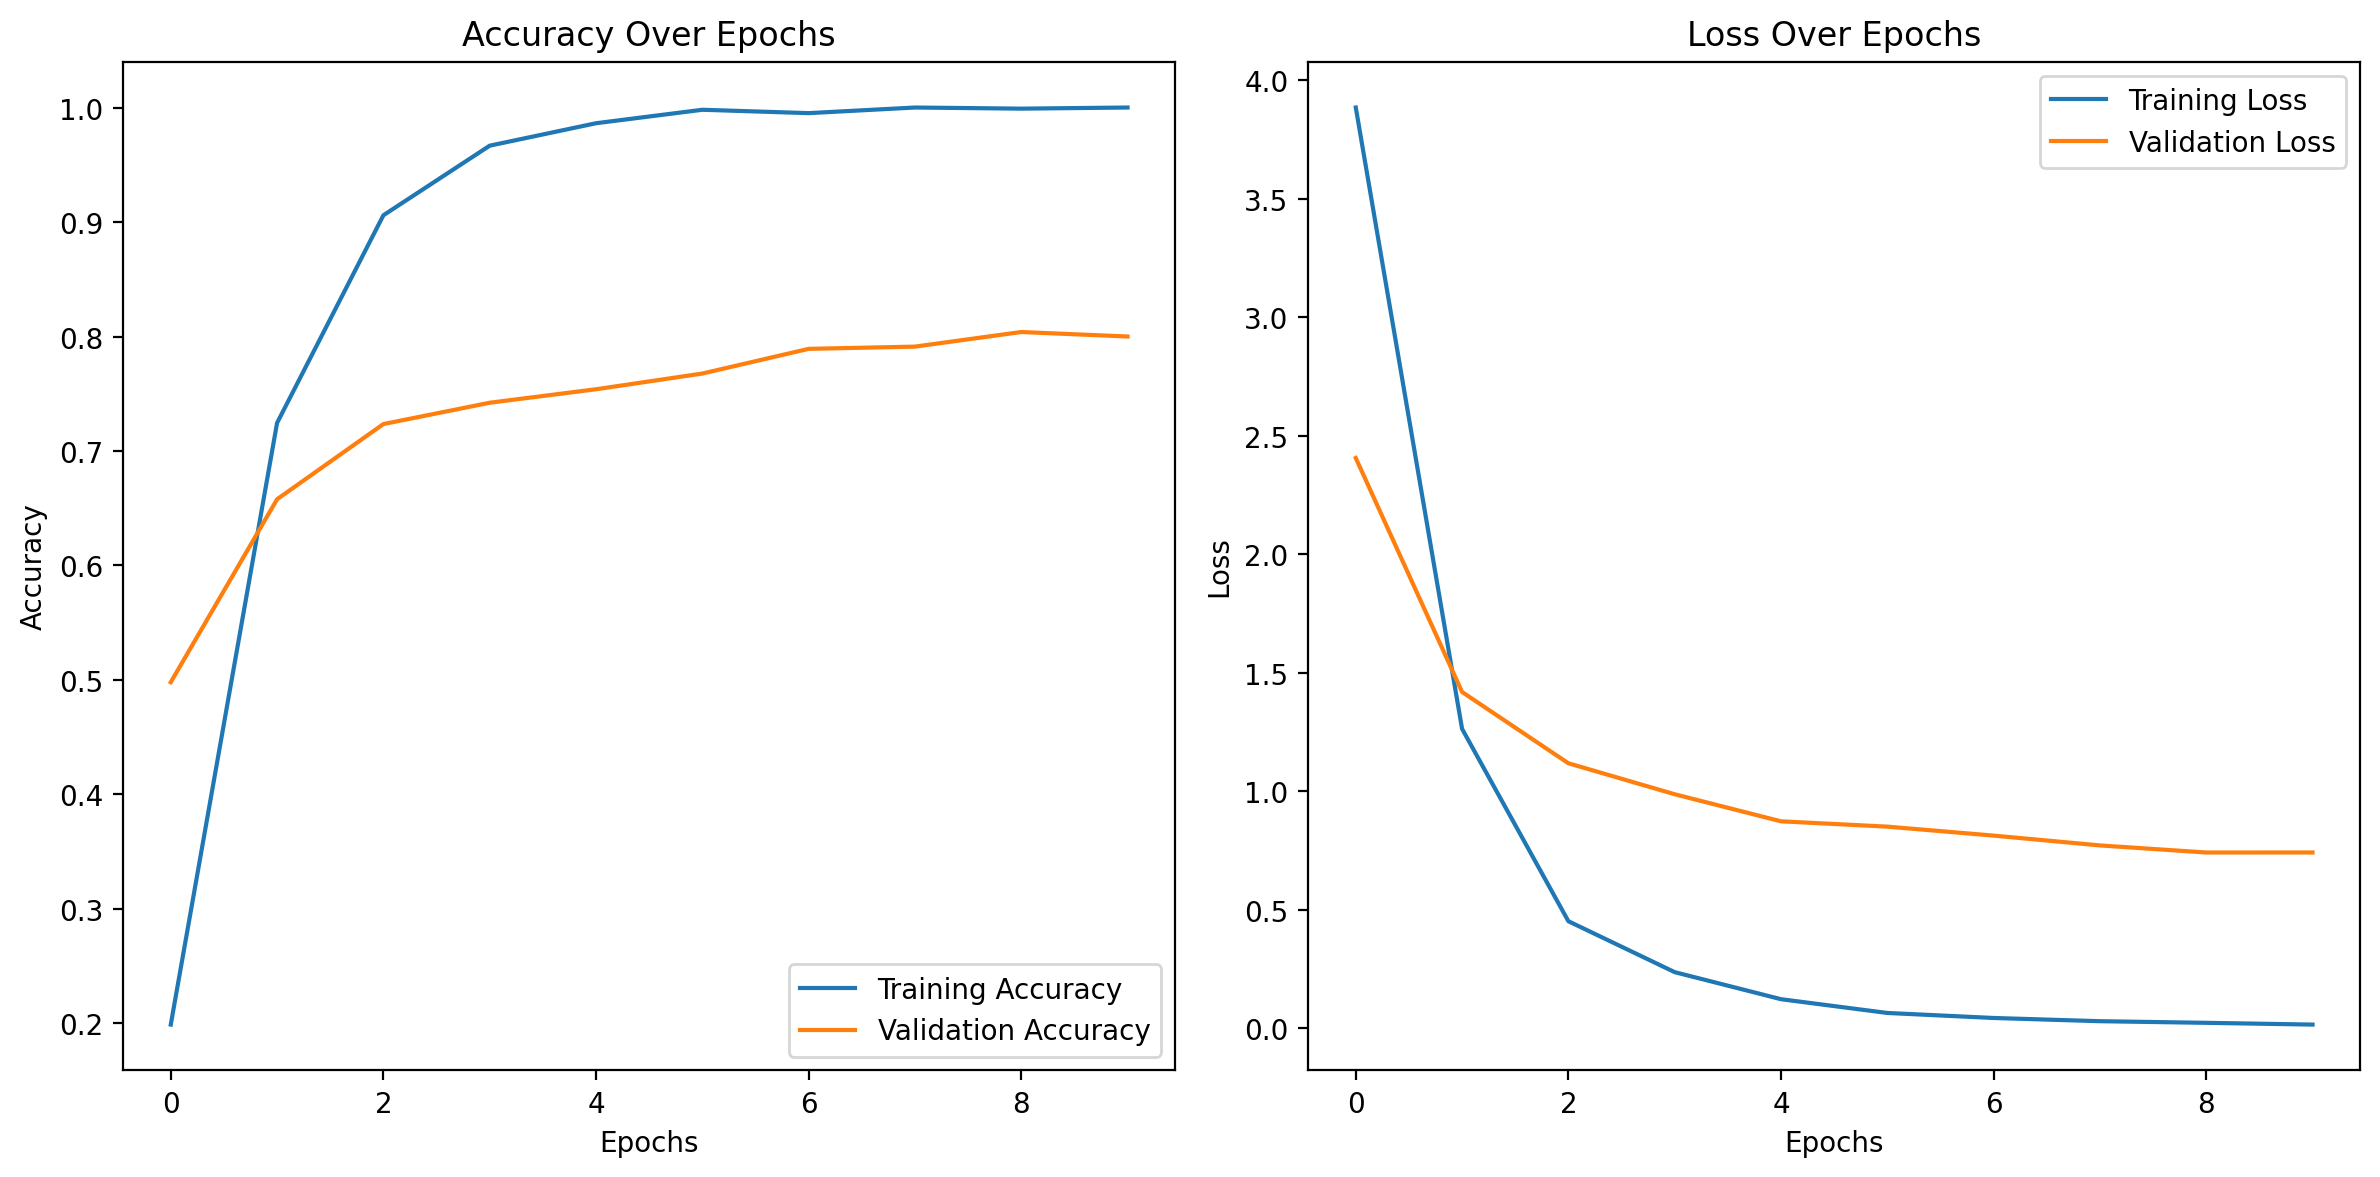

In [18]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()


## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [19]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


2025-02-17 20:27:36.987248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [2]
	 [[{{node Placeholder/_3}}]]
2025-02-17 20:27:36.987663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2]
	 [[{{node Placeholder/_1}}]]


193/193 [==============================] - 522s 3s/step - loss: 0.8794 - accuracy: 0.7788
Test Loss: 0.8793582320213318
Test Accuracy: 77.88%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [20]:
# TODO: Save your trained model as a Keras model.
model.save('flower_classifier_model.h5')
print("Model saved successfully!")



Model saved successfully!


## Load the Keras Model

Load the Keras model you saved above.

In [21]:
# TODO: Load the Keras model

from tensorflow.keras.models import load_model
model = load_model('flower_classifier_model.h5')
print("Model loaded successfully!")


Model loaded successfully!


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [22]:
# TODO: Create the process_image function

import tensorflow as tf
import numpy as np
from PIL import Image

def process_image(image_path):
    image = Image.open(image_path)
    image = np.array(image)
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    image = tf.expand_dims(image, axis=0)
    
    return image.numpy()  


To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

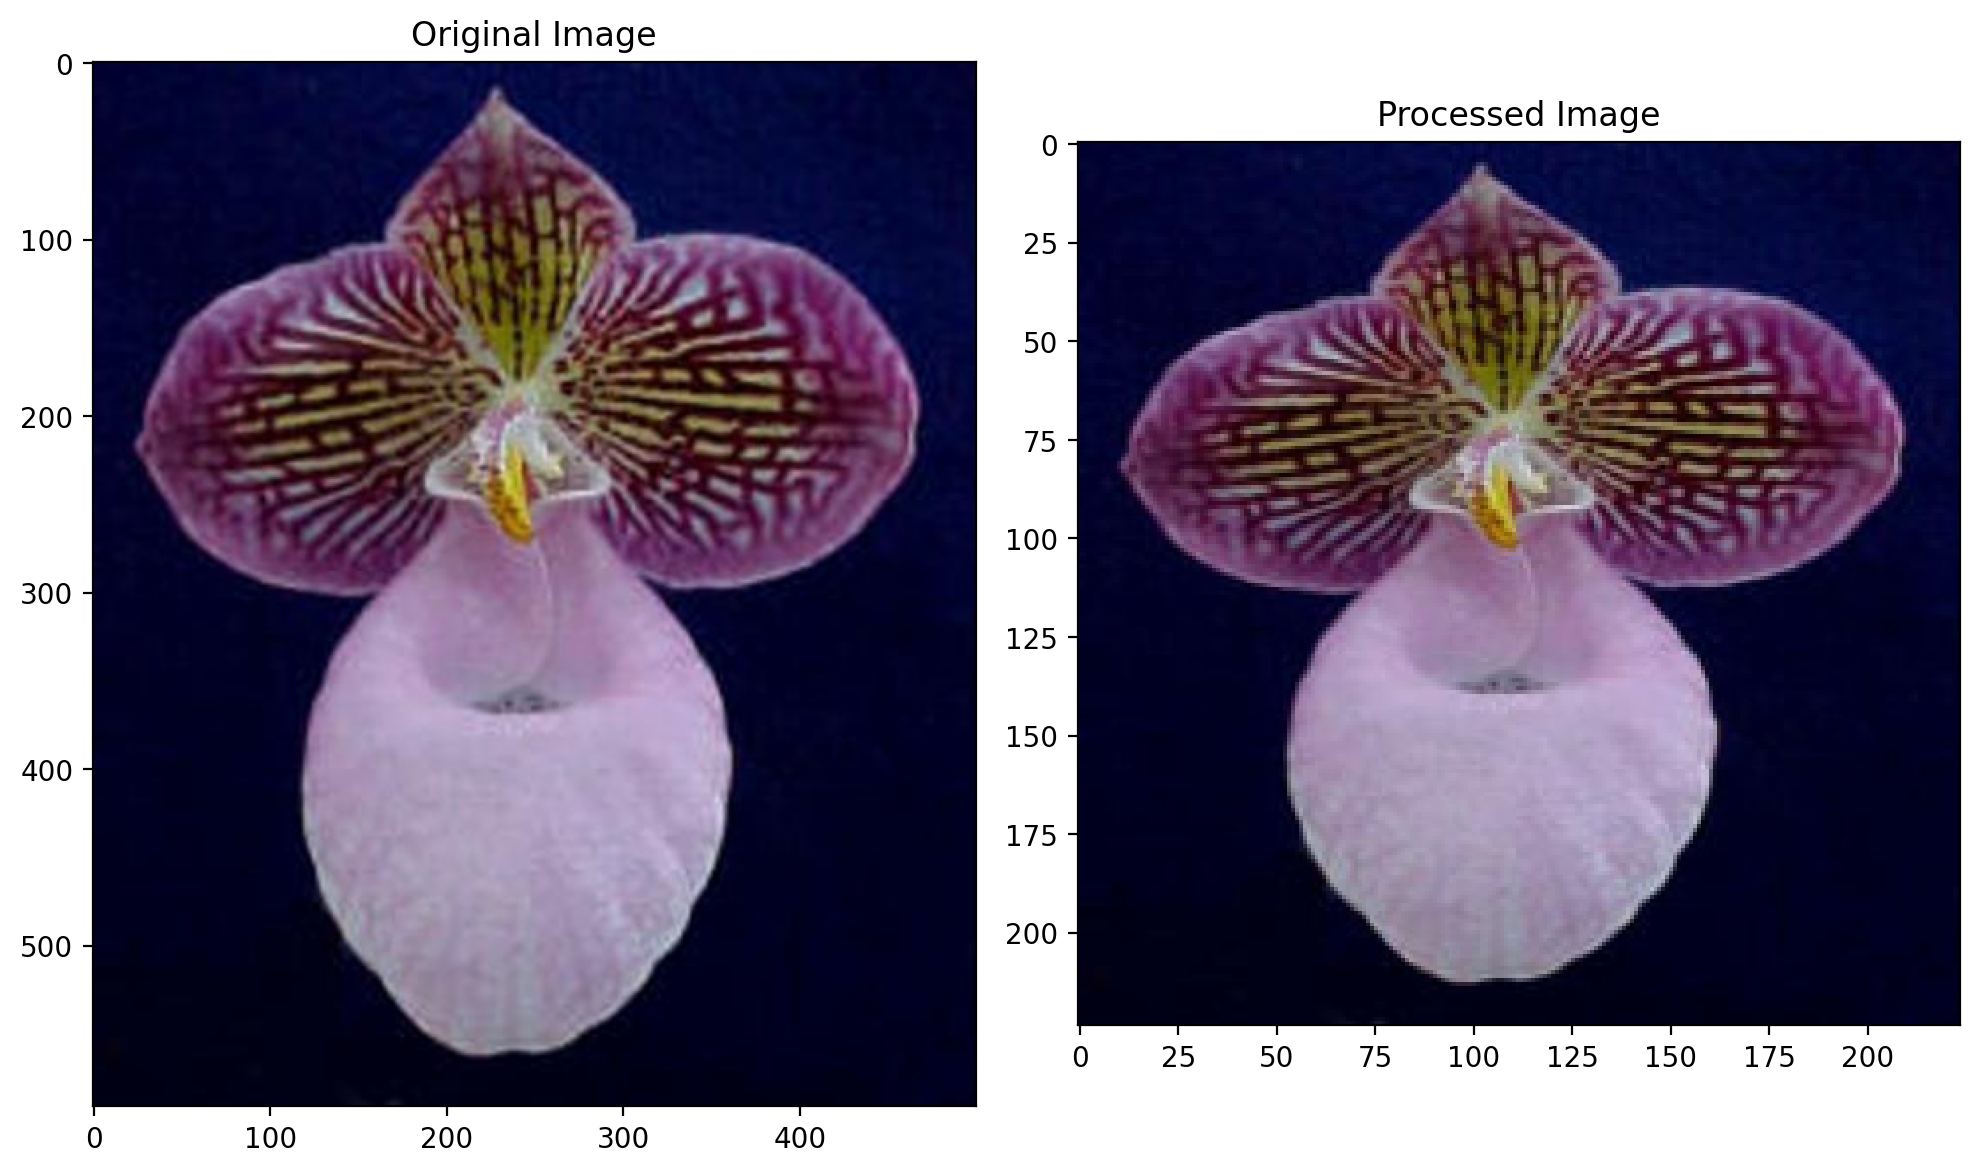

In [24]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)
processed_test_image = process_image(image_path)  

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image[0])  
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()


Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [29]:
def predict(image_path, model, top_k=5):
    processed_image = process_image(image_path)  # This should return an image of shape (224, 224, 3)
    processed_image = np.expand_dims(processed_image, axis=0)
    predictions = model.predict(processed_image)

    top_k_indices = predictions[0].argsort()[-top_k:][::-1]
    top_k_probs = predictions[0][top_k_indices]
    
    class_labels = [str(i) for i in top_k_indices]

    return top_k_probs, class_labels


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

1/1 [==============================] - 2s 2s/step


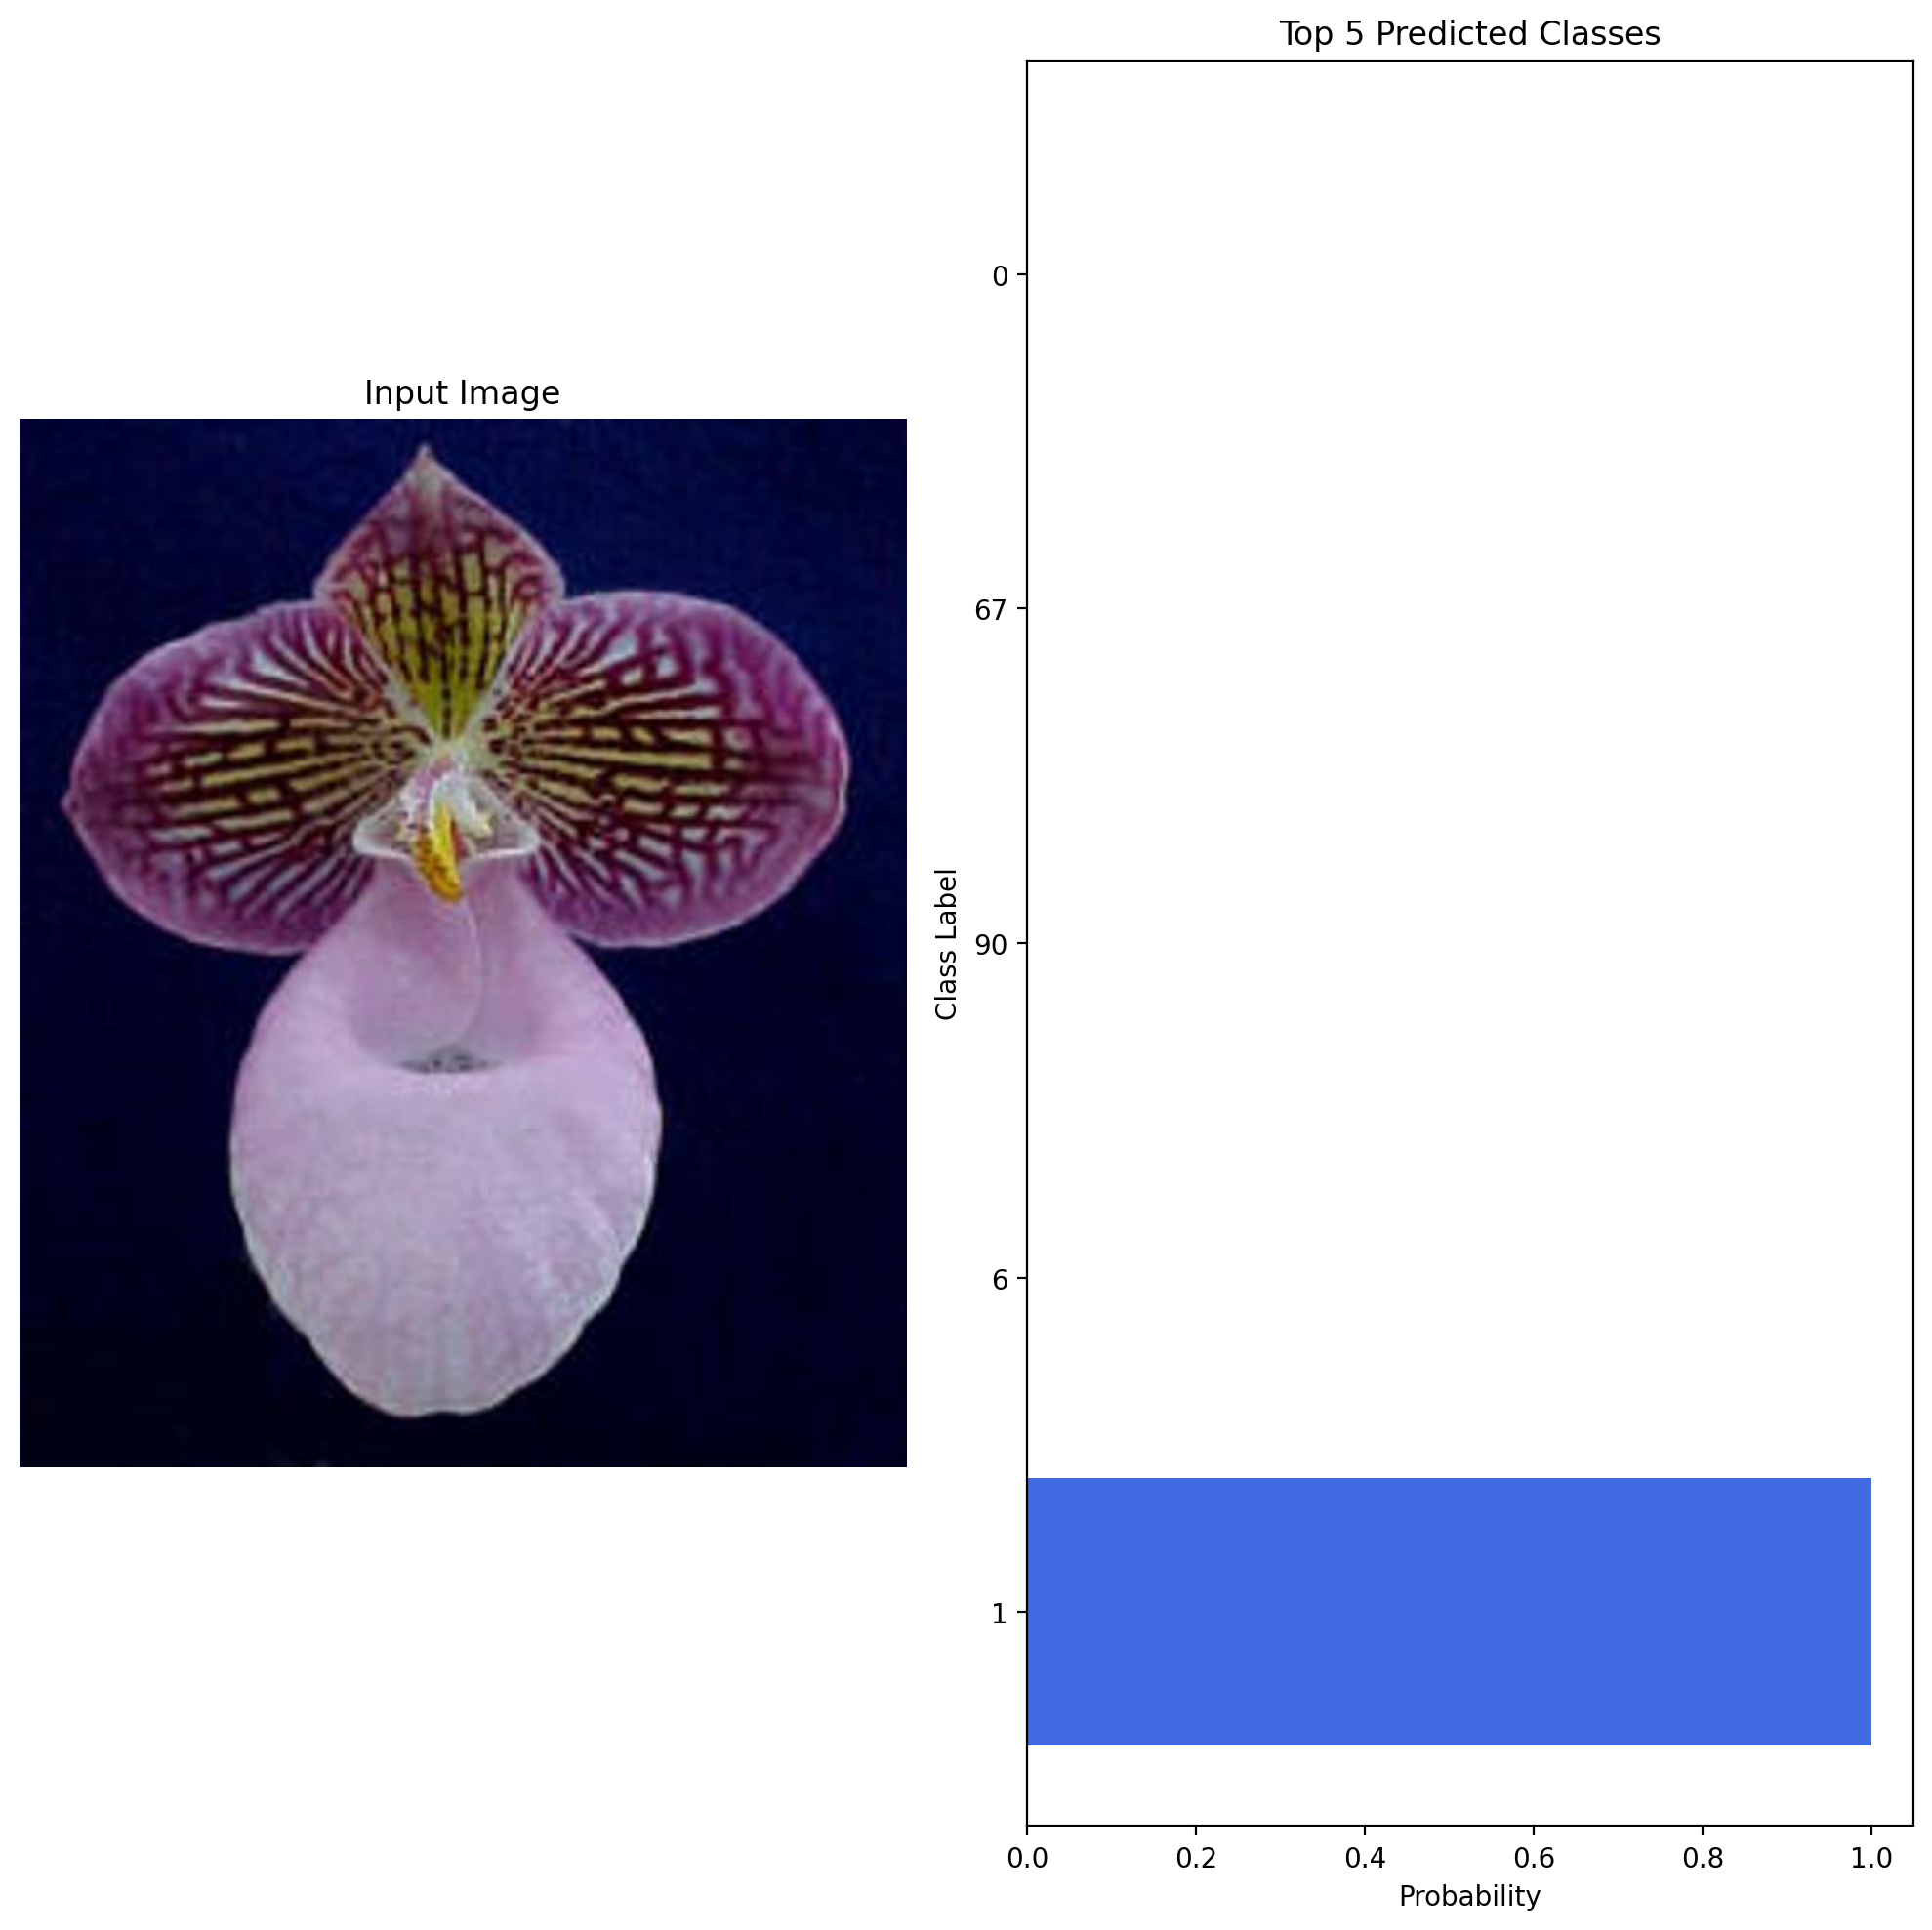

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#  process_image function
def process_image(image_path):
    image = Image.open(image_path)
    image = np.array(image)
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return image

#  predict function
def predict(image_path, model, top_k=5):
    processed_image = process_image(image_path)  
    processed_image = np.expand_dims(processed_image, axis=0)
    predictions = model.predict(processed_image)
    top_k_indices = predictions[0].argsort()[-top_k:][::-1]
    top_k_probs = predictions[0][top_k_indices]
    class_labels = [str(i) for i in top_k_indices]
    return top_k_probs, class_labels

#   plot_predictions function
def plot_predictions(image_path, model, top_k=5):
    probs, classes = predict(image_path, model, top_k)
    # load the image(PIL)
    im = Image.open(image_path)

    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 10), ncols=2)

    # Plot the original image
    ax1.imshow(im)
    ax1.set_title('Input Image')
    ax1.axis('off') 

    # Plot the bar graph for the top K predicted classes
    ax2.barh(classes, probs, color='royalblue')
    ax2.set_xlabel('Probability')
    ax2.set_ylabel('Class Label')
    ax2.set_title(f'Top {top_k} Predicted Classes')
    plt.tight_layout()
    plt.show()

# example 
image_path = './test_images/hard-leaved_pocket_orchid.jpg'

plot_predictions(image_path, model, top_k=5)
